# Python CCD Data Reduction

---

### Names: [Enter your names here]

**Before you do anything else, go to File -> Save a Copy in Drive. Make any requested edits to that copy.**

This notebook walks through the basics of CCD data reduction within python. More detailed instructions (involving more powerful pieces of software) can be found in the CCD Data Reduction Guide written by Matt Craig and Lauren Chambers [https://mwcraig.github.io/ccd-as-book/00-00-Preface](https://mwcraig.github.io/ccd-as-book/00-00-Preface), which itself is based on the [IRAF CCD reduction](http://ircamera.as.arizona.edu/Astr_518/irafguid.pdf) and [stellar photometry](https://www.mn.uio.no/astro/english/services/it/help/visualization/iraf/daophot2.pdf) guides by Phil Massey. 

You will need various fits images for this lab, which can be found on the Astro Server. Mount the server, and look under Shared -> CCD_Data -> 2022 -> 01_03_22 -> Calibration. Upload all of the files with the 'CalR-' prefix. 

**New Code**

* Open and close a fits file.
* Print info about a fits file.
* Access the data and the header within a fits file.
* Access the elements of a header.
* Set the x-axis range of a plot.
* Calculate the median along one axis of a multi-dimensional array.
* Read in just the header from a fits file.
* Add a new keyword to a fits header.
* Turn a multi-dimensional array into a one-dimensional array.
* `enumerate`
* Create a new HDU object
* Save the HDU object to a fits file
* `/=`, `*=`, `+=`, `-=`
* `array.shape`

### Pseudo-code

Trying to remember all of the exact syntax of various python statements can often get in the way of figuring out how to set up a program. Knowing whether or not to use a for loop is a separate problem than knowing the exact syntax of a for loop. Pseudo-code uses a mixture of code and plain english to represent a program in a way that avoids any concerns about syntax, but still makes clear how the program is designed to work.

As an example, lets consider the function from the first lab that took in an array of numbers and returned the sum of these numbers. The exact python code was:

 ```
 def sum_func(array_like):
    out_sum = 0
    for i in array_like:
        out_sum += i
    return out_sum
```

Converting to pseudo-code this becomes:

```
sum_func(an array of numbers)
  Set initial sum to 0
  For each element in input array of numbers:
    Add element to sum
  Return sum
```

From this pseudo-code you can see that you will need a variable that contains the sum, and you need to know the syntax for looping over the elements in a list. The pseudo-code doesn't worry about exact variable names, or exact syntax, but does include the for loop and the return statement. 

Now lets consider an example of going in the other direction (converting from psuedo code to actual code). In the first lab you wrote a function that would go through a list of students and their grades and sort the students as either proficient or struggling. The pseudo-code version of this algorithm looks like:

```
For student and grade in class list
  If grade is greater than average grade
    Add student to profcient student lest
  Else
    Add student to struggling student list
```

This pseudo-code makes it clear that we need to loop over every student in the list, and compare the grade of that student to the average for the class. Based on this comparison the student is either added to the proficient student list or the struggling student list.

From this psuedo-code you can imagine how to construct the actual piece of code. You will need lists for proficient students and struggling students, and you need to be able to add new entries to each of these lists. You will need to know the average grade for the class, as well as have a class list that contains names and grades (these may be defined earlier in the code). You will also need to figure out how to loop over the class list in a way that gives you access to both the grade and the student name. The exact python code for completing this task was:

```
proficient_studnts = []
struggling_students = []
for i in class_grades:
  if float(i[1]) > mean_score:
    proficient_students.append(i)
  else:
    struggling_students.append(i)
```

There are no formal rules for pseudo-code, or for how detailed to be when writing pseudo-code. Being too general isn't helpful (i.e., replacing the second example with `sort the students based on their grade` is not very helpful) but if you include too much detail then you end up just writing the function. Psuedo-code is best viewed as a tool to help you think about how a piece of code is structured, without worrying about the exact syntax. Include as much, or as little, detail as is helpful for you to understand how the code operates. 

### Reducing CCD Data

Any data taken at an observatory must go through a number of steps before it can be used for scientific analysis. This includes correcting for the bias level, the dark current, and inhomogneities in the sensitivity across the detector. These cotributions can be accounted for with the use of bias frames, dark frames, and flat field images. *Bias frames* are images with an exposure time of zero, and represent the number of counts that each pixel starts with before any contribution from the sky, or other sources of electrons. *Dark frames* represent the contribution from the thermal electrons; they are matched to the exposure time of the science image since the thermal signal increases with time. *Flat field frames* are images of a uniformly illuminated object. Any differences in the recorded signal between different pixels in a flat field image are most likely due to differences in the response rate of different pixels.

Bias and dark frames are subtracted from the science image, while a normalized flat field frame is divided off to produce a processed image. The formula for constructing a useable science image from a raw image is:

$science = \frac{raw - bias - dark}{flat}$

In [1]:
# Load in the necessary packages
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

### Bias Frames (and basic fits handling in python)

First, lets read in a bias frame. We will look at the `CalR-0001Bias.fit` file.


We will use the `astropy` package, which includes the ability to read in fits files. Fits files are read into an HDUList object, which is a flexible data type that contains the data as well as the header. [More info about fits files in python can be found on the [astropy.io.fits documentation page.]((https://docs.astropy.org/en/stable/io/fits/)]

Below, after reading in the fits file into the variable `bias1`, we use the `.info()` function to print information about the fits file.

In [2]:
from astropy.io import fits

# Read in a bias frame
bias1 = fits.open('CalR-0001Bias.fit')
bias1.info() # print basic info about the fits file

Filename: CalR-0001Bias.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (1024, 1024)   int16 (rescales to uint16)   


The output of the `.info()` function says that this fits file has one extension (since there is only one line of output), and has dimensions 1024x1024. The data and header for this extension can be accessed using the `.data` and `.header`, as shown below. If other extensions existed, they could be accessed in a similar manner, by simply changing the index. All of the files that you will look at today will only have one extension.

In [3]:
bias_data = bias1[0].data
bias_header = bias1[0].header

The header is a dictionary and individual elements, such as the image type and the exposure time, can be accessed as with dictionaries. We can print off all of the keys to see what they are.

In [4]:
print('Image Type: {}'.format(bias_header['imagetyp'])) #Image type header keyword
print('Exposure Time: {}'.format(bias_header['exptime'])) #Exposure time image keyword
print('---')
for key in bias_header.keys():
  print(key) #Print out the keys

Image Type: Bias Frame
Exposure Time: 0.0
---
SIMPLE
BITPIX
NAXIS
NAXIS1
NAXIS2
BSCALE
BZERO
DATE-OBS
EXPTIME
EXPOSURE
SET-TEMP
CCD-TEMP
XPIXSZ
YPIXSZ
XBINNING
YBINNING
XORGSUBF
YORGSUBF
READOUTM
IMAGETYP
FOCALLEN
APTDIA
APTAREA
SBSTDVER
SWCREATE
SWSERIAL
SITELAT
SITELONG
JD
OBJECT
TELESCOP
INSTRUME
OBSERVER
NOTES
FLIPSTAT
SWOWNER


The data themselves are a numpy array, and the flux in individual pixels can be accessed in the same way as with any two-dimensional array. As we saw based on the result from the `.info()` function the data has dimensions 1024x1024. We can verify the dimensions by looking at the shape of the array.

In [5]:
print('Shape of the array: {}'.format(bias_data.shape))

Shape of the array: (1024, 1024)


Since it is a regular numpy array, we can access the flux values at various locations

In [6]:
print('Flux in corner element: {}'.format(bias_data[0,0]))

Flux in corner element: 1679


The `convenience_functions.py` file contains a function called `show_image` that can help in displaying images.


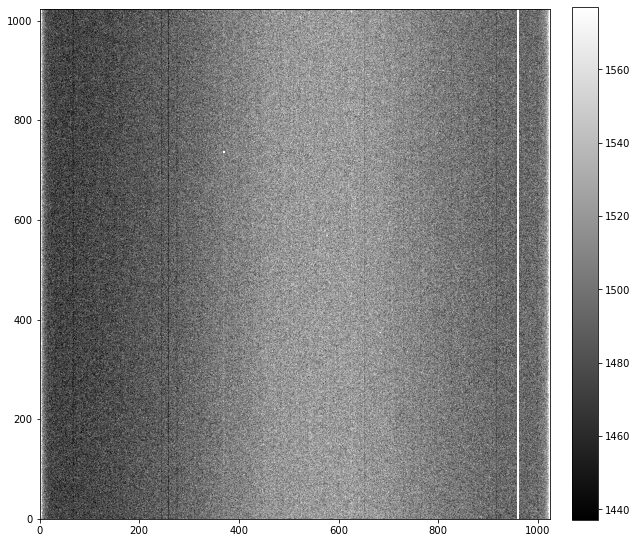

In [7]:
from convenience_functions import show_image #<- Load the show_image function
show_image(bias_data,cmap='gray') 

As a bias frame, this image represents the state of the detector before it has been exposed to light. Variations in pixel value are partly due to read noise, as well as defects in the detector. We can look at the distribution of pixel values using the `hist` function from matplotlib, which we met in the first lab.

Text(0.5, 1.0, 'Distribution of Bias Counts')

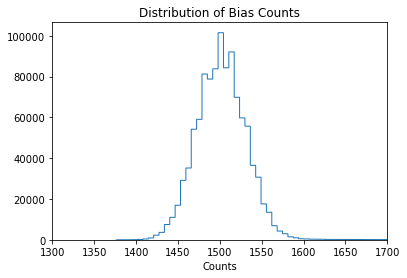

In [8]:
plt.hist(bias_data.flatten(),10000,histtype='step')
plt.xlim(1300,1700) #<-- What does this line do?
plt.xlabel('Counts')
plt.title('Distribution of Bias Counts')

> **Q:** To the above code block, add code to label the X-axis as 'Counts' and add the title 'Distribution of Bias Counts'.

> **Q:** What does the `plt.xlim(1300,1700)` line do? You can either look up the answer on the interwebs, use the help function to look at its docstring, or you can play around with the values to see what changes.
>
> **A: Sets the x-range of the figure.**

### Dark Frames

Now lets look at a dark frame.

> **Q:** As we did with the bias frame, read in the first dark frame (`CalR-0001Dark.fit`) from the `Cal_data` folder and display the image using the `show_image` function.

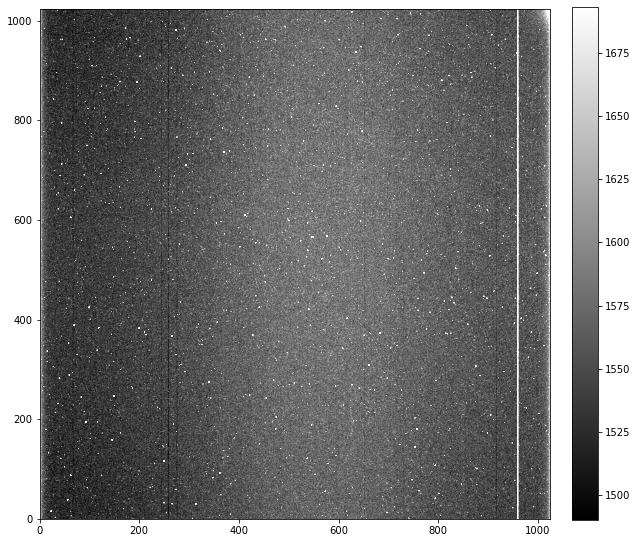

In [9]:
# Read in the dark frame, and display the image
dark1 = fits.open('CalR-0001Dark.fit')
dark1_data = dark1[0].data
show_image(dark1_data,cmap='gray')

The dark frame represents the contribution from thermal electrons. The image was taken with the shutter closed and an exposure time of sixty seconds. The pixel values are only slightly higher than the bias frame, suggesting that the dark current is not very high. We can calculate the dark current by subtracting a bias image, and then dividing the result by the exposure time.

> **Q:** The following function calculates the average dark current, in electrons per second, absed on a given dark frame. *But there are errors and missing lines in the function.* Correct the errors and missing lines so that the function runs properly.

In [10]:
def calc_dark_current(dark_filename):
  dark_image = fits.open(dark_filename)#Insert code that reads the fits file dark_filename into the variable dark_image
  dark_data = dark_image[0].data
  dark_header = dark_image[0].header ## Remove bias_
  exp_time = dark_header['exptime']#Insert code that reads the exptime keyword from the header, places this value in the variable exp_time
  dark_image.close()
  gain = 2.
  avg_dark_current = gain*np.mean(dark_data-bias_data)/exp_time #missing n on mean
  print('Average Dark current: {:0.2f} e-/sec'.format(avg_dark_current)) #avg_current -> avg_dark_current, missing last )

calc_dark_current('CalR-0001Dark.fit') #file name needs to be a string

Average Dark current: 104.77 e-/sec


> **Q:** Convert the function defined above from code into pseudo-code

```
calc_dark_current(filename)
  read in dark image
  read data and header into variables
  pull out exposure time
  close fits file
  calculate the dark current
  print the dark current
```

### Flat Field

Now lets look at the flat field

> **Q:** As we did with the bias frame, read in the first flat field frame (`CalR-0001R.fit`). Display the image using the `show_image` function.

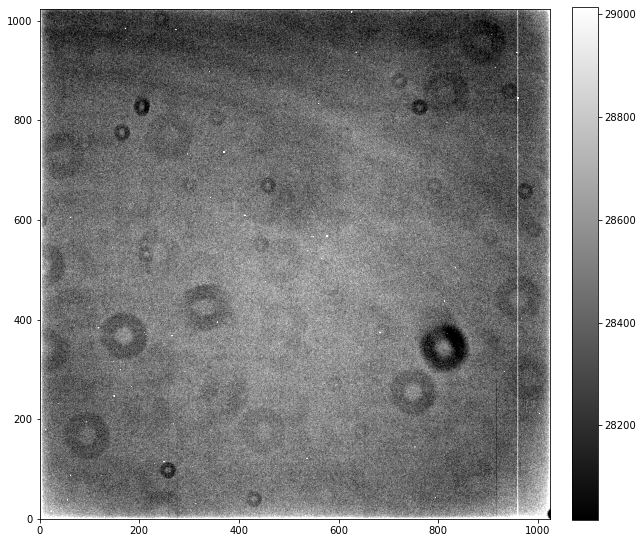

In [11]:
# Read in a flat field, and display the image.
flat1 = fits.open('CalR-0001R.fit')
flat1_data = flat1[0].data
show_image(flat1_data,cmap='gray')

### Reducing science data

A science image needs to be corrected for the dark, bias, and flat field. This can be done based on individual dark, bias, and flat field images but it is much better to combine multiple frames. This is because each frame contains read noise on the individual pixels. By average multiple frames we can reduce the contribution of the read noise.

The following introduces how to combine multiple frames, and how to save the output. First we will set up a dictionary that contains the names of all of the calibration files. This includes the bias frames, the dark frames, and the flat field images for each filter.

In [12]:
# Create a dictionary with the file names of the bias frames, dark frames, and flat field frames
data_files = {'biases':['CalR-00%02dBias.fit' % x for x in range(1,11)],
              'darks':['CalR-00%02dDark.fit' % x for x in range(1,6)],
              'Rflats':['CalR-00%02dR.fit' % x for x in range(1,6)]}

Next we will open each bias frame and save the data into one large master array (`bias_data`)

In [13]:
from astropy.utils import data
# Read in the bias frames
bias_data = np.zeros((len(data_files['biases']),1024,1024)) # First creat an empty numpy array with the right dimensions
for i,file in enumerate(data_files['biases']):
  image = fits.open(file)
  bias_data[i,:,:] = image[0].data
  image.close()

In the for loop above, I introduced the `enumerate` function. This function takes in a list and returns two items: the first is an index, and the second is the value of the list at that index. We can see how this works if I run a simple for loop that prints out the two variables.

In [14]:
for i,file in enumerate(data_files['biases']):
  print(i,file)

0 CalR-0001Bias.fit
1 CalR-0002Bias.fit
2 CalR-0003Bias.fit
3 CalR-0004Bias.fit
4 CalR-0005Bias.fit
5 CalR-0006Bias.fit
6 CalR-0007Bias.fit
7 CalR-0008Bias.fit
8 CalR-0009Bias.fit
9 CalR-0010Bias.fit


As it steps through the elements of the list, the `enumerate` function returns the index at each position, and the value of the list at that position. When employed in the for loop, this allows us to use the file name for reading in the fits file, and then use the index when placing the data within our combined array.

Now lets return to the `bias_data` variable. This is a three dimensional array, with dimensions (Number of bias frames) x (Number of rows) x (Number of columns). As with the numpy array, individual elements can be specified using square brackets, but now three indeces need to be specified. The for loop above puts each image into a different portion of the array, so that all of the data is accessible in one array.

> **Q:** Which of the following lines of code selects the center pixel of the 1st image? (Delete the incorrect answers)
>
> `bias_data[512,512,1]`
>
> `bias_data[1,512,512]`
>
> `bias_data[0,512,512]`
>
> `bias_data[512,512,0]`

**bias_data[0,512,512]**

Note that for a 2D image the x-axis (FITS NAXIS1) is the *second* index, while the y-axis is the first index. Selecting out the flux at e.g. x=10, y=45 in the first image would use the code `bias_data[0,44,9]`.

> **Q:** Which of the following selects out the pixels in the first image with 220 < x < 240 and 450 < y < 470? (Delete the incorrect answers?
>
> `bias_data[220:240,450:470,0]`
>
> `bias_data[450:470,220:240,0]`
> 
> `bias_data[0,220:240,450:470]`
>
> `bias_data[0,450:470,220:240]`

**bias_data[0,450:470,220:240]**

Next we need to combine all of these images into one image. At each pixel position we want to take the median across all of the images. In this way we construct a new image that has the same dimensions as the original image, but has less noise. This could be done use two for loops (one looping over the rows and the other looping over columns), but the median function within numpy has this functionality built in. The following line of code will take the median along the 1st axis at each position in the 2nd and 3rd axis (e.g., at each pixel position, take the median across all of the images).

In [15]:
combined_bias = np.median(bias_data,axis=0) #<- The axis keyword starts counting at zero

Now lets look at a single bias frame and the combined bias frame side by side.

Text(0.5, 1.0, 'Combined Bias Frame')

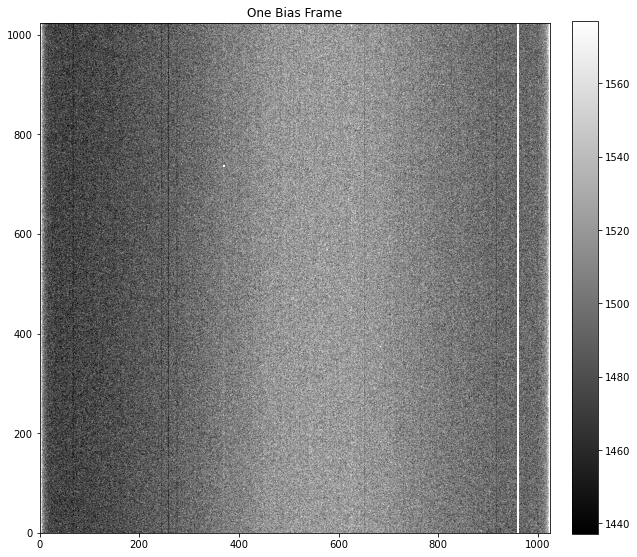

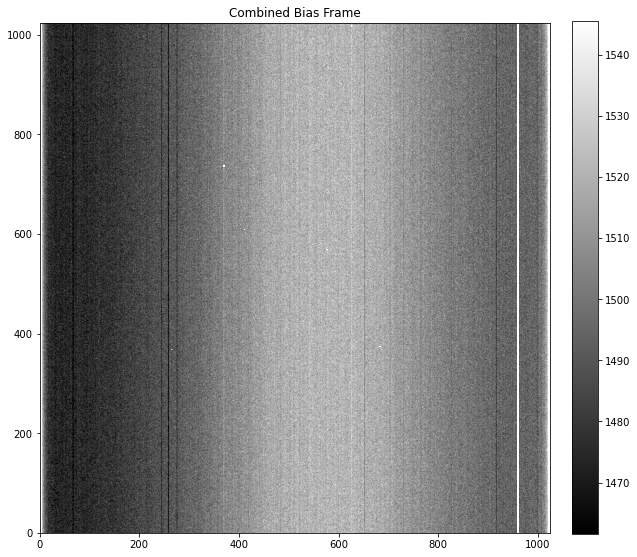

In [16]:
show_image(bias_data[0,:,:],cmap='gray')
plt.title('One Bias Frame')

show_image(combined_bias,cmap='gray')
plt.title('Combined Bias Frame')

Notice how the combined bias frame looks less grainy. That is because the graininess was due to read noise, which is reduced when taking a median combination of multiple frames.

Next we will write out the median-combined bias frame so that we can access it later.

In [17]:
# Write out the combined bias file

# First read in the header from one of the bias files, and add a comment to say that this is a combined file
hdr = fits.getheader('CalR-0001Bias.fit') #<- Read in just the header. This saves time and memory
hdr['history'] = 'Median combination bias frame' #<- Add a new keyword, with the given value (just like any other dictionary).

# Create a new HDU object
hdu = fits.PrimaryHDU(combined_bias,hdr)
hdu.writeto('combined_bias.fits',overwrite=True)

Now we want to do the same thing for the dark and flat field frames. The procedure is very similar, with two additional considerations:


*   We must subtract the bias level from each dark frame before they are median-combined. We want the final combined dark image to only represent the dark current, not the dark current plus the bias level.
*   Each flat image must have the bias level subtracted, as well as the dark current. After created a combined flat field image, we then need to normalize this combined image, which we can do by dividing the image by its median value.






> **Q:** In the space below, write out the pseudo-code for processing the flat field frames.

```
for every flat field image
  load flat field image
  subtract dark current and bias from from the image
  add flat field image to 3-dimensional array

median combine the flat field images
normalize the median combination by its median value

read in header of a flat field image
add history keyword
create new hdu object with new header and median combined, normalized flat field array
write out fits file
```



Lets start with the dark frame.

> **Q:** The code below gives the basic outline for creating a median-combined, bias-subtracted dark frame. Insert the necessary lines of code to complete this code block. (There are no intentional errors in this code block, just missing pieces of code.)


In [18]:
# Now lets do the same for the dark frame, making sure to subtract of the bias

# Read in the dark frames
dark_data = np.zeros((len(data_files['darks']),1024,1024))
for i,file in enumerate(data_files['darks']):
  image = fits.open(file)
  dark_data[i,:,:] = image[0].data-combined_bias #Insert code to input the dark image data, while subtracting off the bias
  image.close()

# Insert code to median combine the dark_data array
combined_dark = np.median(dark_data,axis=0)

# Write out the combined dark file
# First read in the header from one of the dark files, and add a comment to say that this is a combined file
hdr = fits.getheader('CalR-0001Dark.fit')
hdr['history'] = 'Median combined dark frame'

# Create an HDU object from the data and header, and write out the result.
hdu = fits.PrimaryHDU(combined_dark,hdr)
hdu.writeto('combined_dark.fits',overwrite=True)

Text(0.5, 1.0, 'Combined Dark')

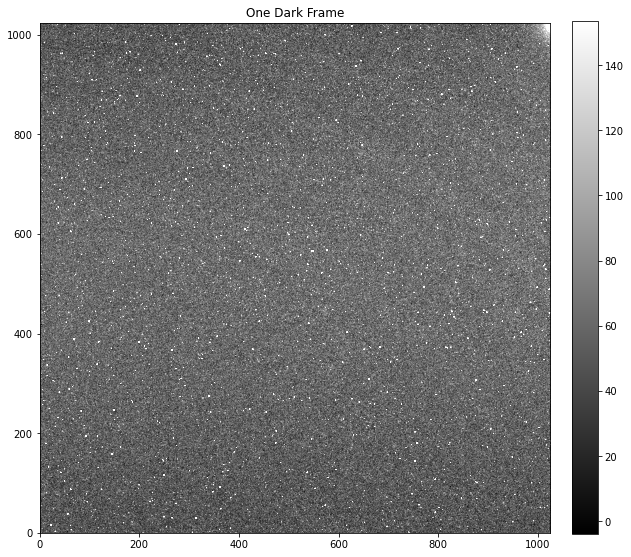

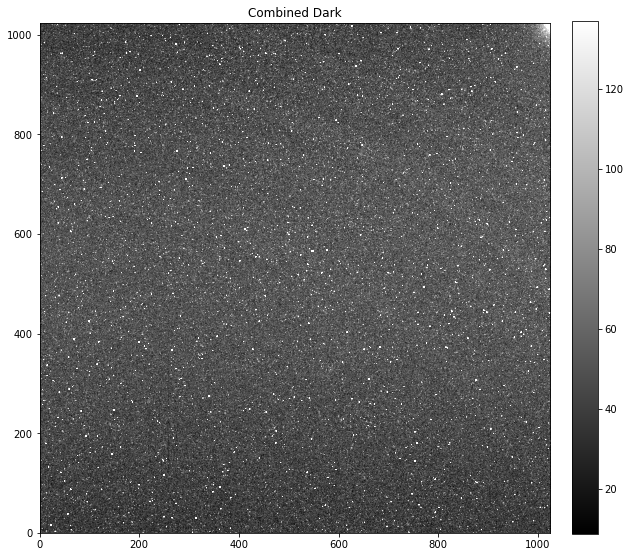

In [19]:
show_image(dark_data[0,:,:],cmap='gray')
plt.title('One Dark Frame')

show_image(combined_dark,cmap='gray')
plt.title('Combined Dark')

> **Q:** Now repeat for the flat field images. Make sure to subtract off both the bias level and the dark current. The dark current must be scaled to the exposure time of the flat field images. To do this, divide the combined dark current image by the exposure time of the dark current image (120 seconds) to get the dark current per second, and then multiply by the exposure time of the flat field image.

In [20]:
from astropy.io.fits import header
flat_data = np.zeros((len(data_files['Rflats']),1024,1024))
for i,file in enumerate(data_files['Rflats']):
  image = fits.open(file)
  header = image[0].header
  exptime = header['exptime']#Insert code to read in the exposure time from the header
  flat_data[i,:,:] = image[0].data-combined_bias-combined_dark/120.*exptime#Insert code to read the data from the image, and subtract both the bias and the scaled dark
  image.close()

# Insert code to median combine the flat data, and place the results into a variable called combined_flat
combined_flat = np.median(flat_data,axis=0)
# Next, normalize the flat field image.
#    Both of the following statements are equivalent (we keep one commented out because we don't want to divide twice)
combined_flat = combined_flat/np.median(combined_flat)
#combined_flat /= np.median(combined_flat)

# First read in the header from one of the flat files, and add a comment to say that this is a combined file
hdr = fits.getheader('CalR-0001R.fit')
hdr['history'] = "Median combined flat frame"

#Insert code to create a new HDU object, using the combined_flat and hdr.
hdu = fits.PrimaryHDU(combined_flat,hdr)
hdu.writeto('combined_Rflat.fits',overwrite=True)
#Save the result as combined_Rflat.fits

Text(0.5, 1.0, 'Combined Flat')

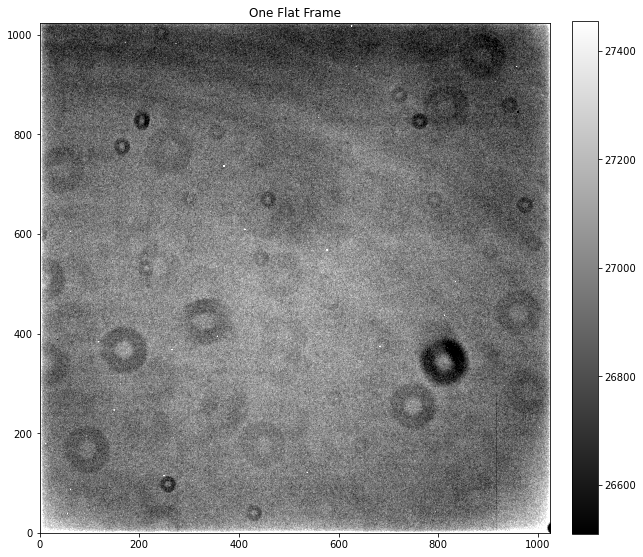

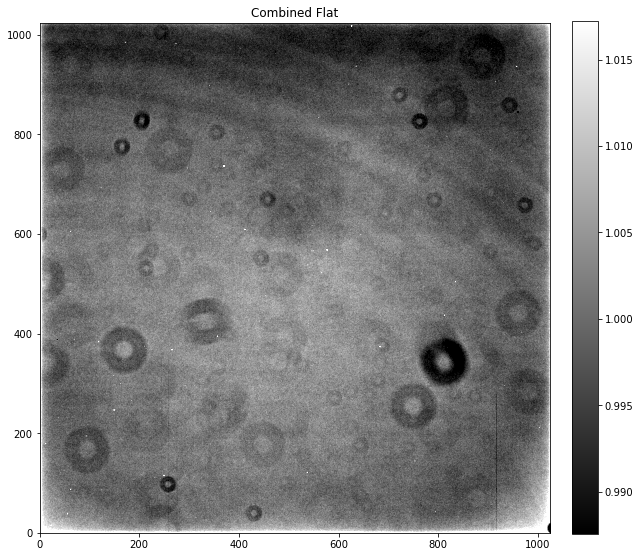

In [21]:
show_image(flat_data[0,:,:],cmap='gray')
plt.title('One Flat Frame')

show_image(combined_flat,cmap='gray')
plt.title('Combined Flat')

Now that we have our master bias, dark, and flat field images, we can apply them to a science image.

> **Q:** Below is the beginning of a function that will read in a science image, and then perform the bias/dark/flat corrections. We want to write a function that takes as inputs the filename of the raw image (as a string), the filename of the output file (a string, and it should be different from the original filename), and the name of the bias, dark, and flat field frames. The function reads in the bias, dark, flat field, and science images, performs the necessary calibrations to the science image, and then writes out the calibrated science frame.
>
> First write out the psuedo-code for this function in the space below.


```
def process_data():
  Open bias, dark, and flat frames
  Read in data from bias, dark, and flat fits files
  Close bias, dark, and flat fits files

  open the fits science file
  Read in the data
  Read in the exposure time from the header
  subtract the bias and scaled dark current, and divide by the flat field
  close the fits science file

  add new keyword to header of science fits file
  create new hdu, with processed data and new header
  write out new hdu file, with new file name
```


> **Q:** Next, convert from your pseudo-code to actual code in the space below.

In [22]:
def process_data(filename,new_filename,bias_file='combined_bias.fits',dark_file='combined_dark.fits',flat_file='combined_Rflat.fits'):

  science_image = fits.open(filename)# Insert code here
  science_data = science_image[0].data#Insert code here
  hdr = science_image[0].header#Insert code here
  exptime = hdr['exptime']#Insert code here
  science_image.close()

  bias_image = fits.open(bias_file)#Insert code here
  bias_data = bias_image[0].data #Insert code here
  bias_image.close()


  dark_image = fits.open(dark_file) #Insert code here
  dark_data = dark_image[0].data #Insert code here
  dark_image.close()


  flat_image = fits.open(flat_file) #Insert code here
  flat_data = flat_image[0].data #Insert code here
  flat_image.close()


  proc_data = (science_data-bias_data-dark_data/120.*exptime)/flat_data #Insert code here

  #Insert code here
  hdr['history'] = 'Bias/Dark subtracted, and flat fielded'
  hdu = fits.PrimaryHDU(proc_data,hdr)
  hdu.writeto(new_filename,overwrite=True)
  


/var/folders/n3/_s65fc7n5jd4gll4g_xrvwzc0000gq/T/ipykernel_17976/112970893.py:24: RuntimeWarning: invalid value encountered in true_divide
  proc_data = (science_data-bias_data-dark_data/120.*exptime)/flat_data #Insert code here


Text(0.5, 1.0, 'Processed Image')

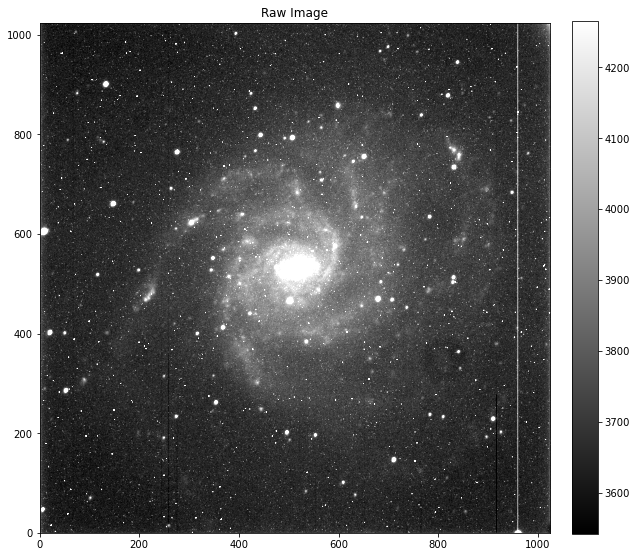

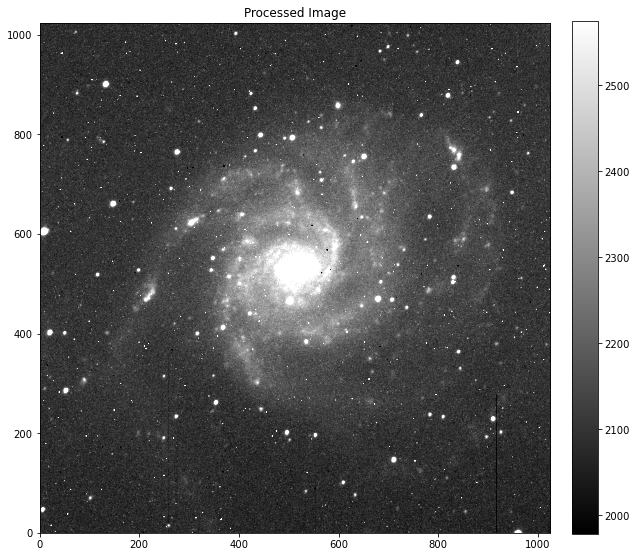

In [23]:
#from astropy.utils import data
#from astropy.utils import data
#Test your code using this code block
process_data('M101_MartiC_180-0001.fit','M101_MartiC_180-0001_proc.fits')

old_image = fits.open('M101_MartiC_180-0001.fit')
old_data = old_image[0].data
old_image.close()

new_image = fits.open('M101_MartiC_180-0001_proc.fits')
new_data = new_image[0].data
new_image.close()

show_image(old_data,cmap='gray')
plt.title('Raw Image')

show_image(new_data,cmap='gray')
plt.title('Processed Image')

### Putting it all together

Now that you know how to process data, you can start to do some analysis with processed data. Let's look at the supernova in M101 from 2023. The files M101_1.fit, M101_2.fit, M101_3.fit, M101_4.fit, and M101_5.fit are images of M101, one taken before the supernova exploded, and the rest taken after the supernova exploded. Use these images to measure how the brightness of the supernova changed with time.

To do this:

1. Process each of the images using the function that you created.

2. Sum up the flux in a small box in a region around the supernova. The box size should be large enough to encompass the supernova, but not include too much contaminating flux from surrounding material in the galaxy. Use the same box size for all three images. For the pre-supernova image, use the location where the supernova shows up in the subsequent images.

3. From the header of each image, find the date when the image was collected.

4. Plot the flux of the supernova as a function of the number of days since the first image. Make sure to label the axes of the plot. 

(Read in M101 images from a couple of days before and after the supernova went off. Calculate the total flux and plot the light curve. They would need to process the data, sum up the flux in a region around the supernova (or just take the maximum flux from this region?), read the date the data was taken from the header, and then create a plot from the results. )
* Double check that they know how to sum up the flux from a sub-region of a 2d array.
* Select out the images that they should use. 

*BONUS: Since you will be repeating the same task, use loops to simplify your code.*

In [24]:
process_data('M101_1.fit','M101_1_proc.fits')
process_data('M101_2.fit','M101_2_proc.fits')
process_data('M101_3.fit','M101_3_proc.fits')
process_data('M101_4.fit','M101_4_proc.fits')
process_data('M101_5.fit','M101_5_proc.fits')

image1 = fits.open('M101_1_proc.fits')
image2 = fits.open('M101_2_proc.fits')
image3 = fits.open('M101_3_proc.fits')
image4 = fits.open('M101_4_proc.fits')
image5 = fits.open('M101_5_proc.fits')

hdr1 = image1[0].header
hdr2 = image2[0].header
hdr3 = image3[0].header
hdr4 = image4[0].header
hdr5 = image5[0].header

data1 = image1[0].data
data2 = image2[0].data
data3 = image3[0].data
data4 = image4[0].data
data5 = image5[0].data

/var/folders/n3/_s65fc7n5jd4gll4g_xrvwzc0000gq/T/ipykernel_17976/112970893.py:24: RuntimeWarning: invalid value encountered in true_divide
  proc_data = (science_data-bias_data-dark_data/120.*exptime)/flat_data #Insert code here


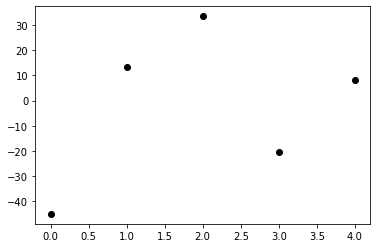

In [29]:
sn1 = np.median((data1[610:640,300:320]-2700))
sn2 = np.median((data2[600:630,300:320]-3000))
sn3 = np.median((data3[600:630,300:320]-3300))
sn4 = np.median((data4[600:630,300:320]-10900))
sn5 = np.median((data5[600:630,300:320]-4400))

plt.plot([sn1,sn2,sn3,sn4,sn5],'ok')

### To turn in this lab, share the lab with me using the *Share* button in the upper right.